In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
# gensim用来加载预训练word vector
from gensim.models import KeyedVectors
#KeyedVectors实现实体（单词、文档、图片都可以）和向量之间的映射，实体都用string id表示
#有时候运行代码时会有很多warning输出，如提醒新版本之类的，如果不想乱糟糟的输出可以这样


In [2]:
# 预训练词向量
# 使用gensim加载预训练中文分词embedding
cn_model = KeyedVectors.load_word2vec_format('data/sgns.zhihu.bigram',
                                          binary=False)
# 词向量模型
# 在这个词向量模型里，每一个词是一个索引，对应的是一个长度为300的向量，我们今天需要构建的LSTM神经网络模型并不能直接处理汉字文本，
# 需要先进行分次并把词汇转换为词向量，步骤请参考：
# 0.原始文本：我喜欢文学
# 1.分词：我，喜欢，文学
# 2.Tokenize(索引化)：[2,345，4564]
# 3.Embedding(词向量化)：用一个300维的词向量，上面的tokens成为一个[3，300]的矩阵
# 4.RNN:1DCONV,GRU,LSTM等
# 5.经过激活函数输出分类：如sigmoid输出在0到1间
# 由此可见每一个词都对应一个长度为300的向量

In [3]:
embedding_dim = cn_model['山东大学'].shape[0]  #一词山东大学，shape[0]返回行数
print('词向量的长度为{}'.format(embedding_dim))
print(cn_model['山东大学'])

# 计算相似度
print(cn_model.similarity('橘子', '橙子'))

# dot（'橘子'/|'橘子'|， '橙子'/|'橙子'| ），余弦相似度
sim = np.dot(cn_model['橘子']/np.linalg.norm(cn_model['橘子']),
        cn_model['橙子']/np.linalg.norm(cn_model['橙子']))
print("sim: ", sim)

词向量的长度为300
[-2.603470e-01  3.677500e-01 -2.379650e-01  5.301700e-02 -3.628220e-01
 -3.212010e-01 -1.903330e-01  1.587220e-01 -7.156200e-02 -4.625400e-02
 -1.137860e-01  3.515600e-01 -6.408200e-02 -2.184840e-01  3.286950e-01
 -7.110330e-01  1.620320e-01  1.627490e-01  5.528180e-01  1.016860e-01
  1.060080e-01  7.820700e-01 -7.537310e-01 -2.108400e-02 -4.758250e-01
 -1.130420e-01 -2.053000e-01  6.624390e-01  2.435850e-01  9.171890e-01
 -2.090610e-01 -5.290000e-02 -7.969340e-01  2.394940e-01 -9.028100e-02
  1.537360e-01 -4.003980e-01 -2.456100e-02 -1.717860e-01  2.037790e-01
 -4.344710e-01 -3.850430e-01 -9.366000e-02  3.775310e-01  2.659690e-01
  8.879800e-02  2.493440e-01  4.914900e-02  5.996000e-03  3.586430e-01
 -1.044960e-01 -5.838460e-01  3.093280e-01 -2.828090e-01 -8.563400e-02
 -5.745400e-02 -2.075230e-01  2.845980e-01  1.414760e-01  1.678570e-01
  1.957560e-01  7.782140e-01 -2.359000e-01 -6.833100e-02  2.560170e-01
 -6.906900e-02 -1.219620e-01  2.683020e-01  1.678810e-01  2.068910

In [4]:
# 找出最相近的词，余弦相似度
print(cn_model.most_similar(positive=['大学'], topn=10))

[('高中', 0.7247821688652039), ('本科', 0.6768536567687988), ('研究生', 0.6244412660598755), ('中学', 0.6088206768035889), ('大学本科', 0.595908522605896), ('初中', 0.5883588790893555), ('读研', 0.5778335928916931), ('职高', 0.5767994523048401), ('大学毕业', 0.5767452120780945), ('师范大学', 0.5708829164505005)]


In [5]:
# 找出不同的词
test_words = '老师 会计师 程序员 律师 医生 老人'
test_words_result = cn_model.doesnt_match(test_words.split())
print('在 '+test_words+' 中:\n不是同一类别的词为: %s' %test_words_result)

在 老师 会计师 程序员 律师 医生 老人 中:
不是同一类别的词为: 老人


In [6]:
cn_model.most_similar(positive=['女人','出轨'], negative=['男人'], topn=1)

[('劈腿', 0.5849197506904602)]

In [7]:
# 训练语料 （数据集）
# 本教程使用了酒店评论语料，训练样本分别被放置在两个文件夹里： 分别的pos和neg，
# 每个文件夹里有2000个txt文件，每个文件内有一段评语，共有4000个训练样本，这样大小的样本数据在NLP中属于非常迷你的

# 获得样本的索引，样本存放于两个文件夹中，
# 分别为 正面评价'pos'文件夹 和 负面评价'neg'文件夹
# 每个文件夹中有2000个txt文件，每个文件中是一例评价，一个对一个
import os
pos_txts = os.listdir('data/pos')
neg_txts = os.listdir('data/neg')
print( '样本总共: '+ str(len(pos_txts) + len(neg_txts)) )


样本总共: 4000


In [11]:
# 现在我们将所有的评价内容放置到一个list里
train_texts_orig = [] # 存储所有评价，每例评价为一条string，原始评论
# 添加完所有样本之后，train_texts_orig为一个含有4000条文本的list
# 其中前2000条文本为正面评价，后2000条为负面评价
#以下为读入.txt文件过程
for i in range(len(pos_txts)):
    with open('data/pos/'+pos_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()
for i in range(len(neg_txts)):
    with open('data/neg/'+neg_txts[i], 'r', errors='ignore') as f:
        text = f.read().strip()
        train_texts_orig.append(text)
        f.close()

In [12]:
train_texts_orig[:5]

['早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。\n\n房间本身很好。',
 '宾馆在小街道上，不大好找，但还好北京热心同胞很多~\n\n宾馆设施跟介绍的差不多，房间很小，确实挺小，但加上低价位因素，还是无超所值的；\n\n环境不错，就在小胡同内，安静整洁，暖气好足-_-||。。。呵\n\n还有一大优势就是从宾馆出发，步行不到十分钟就可以到梅兰芳故居等等，京味小胡同，北海距离好近呢。\n\n总之，不错。\n\n推荐给节约消费的自助游朋友~比较划算，附近特色小吃很多~',
 'CBD中心,周围没什么店铺,说5星有点勉强.不知道为什么卫生间没有电吹风',
 '总的来说，这样的酒店配这样的价格还算可以，希望他赶快装修，给我的客人留些好的印象',
 '价格比比较不错的酒店。这次免费升级了，感谢前台服务员。房子还好，地毯是新的，比上次的好些。早餐的人很多要早去些。']

In [13]:
# 进行分词和tokenize
# train_tokens是一个长长的list，其中含有4000个小list，对应每一条评价
train_tokens = []
for text in train_texts_orig:
    # 去掉标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 结巴分词
    cut = jieba.cut(text)
    # 结巴分词的输出结果为一个生成器
    # 把生成器转换为list
    cut_list = [ i for i in cut ]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为索引index
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 如果词不在字典中，则输出0
            cut_list[i] = 0
    train_tokens.append(cut_list)


Building prefix dict from the default dictionary ...
Dumping model to file cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.329 seconds.
Prefix dict has been built succesfully.


In [15]:
train_tokens[:2]

[[4656,
  163,
  710,
  909,
  32,
  328,
  12,
  1899,
  18,
  8685,
  1604,
  1,
  1845,
  144,
  2420,
  153,
  36,
  75,
  3,
  1487,
  571,
  34,
  72],
 [7224,
  15,
  95,
  5976,
  24,
  31233,
  173,
  67,
  2380,
  497,
  9074,
  5139,
  87,
  7224,
  5249,
  103,
  1113,
  1,
  869,
  1487,
  2871,
  333,
  470,
  95,
  67,
  879,
  83986,
  1321,
  57,
  0,
  0,
  1,
  110,
  578,
  562,
  38,
  15,
  95,
  9081,
  457,
  2567,
  10199,
  11216,
  0,
  148,
  148,
  2360,
  2360,
  7215,
  158,
  893,
  1426,
  38,
  1353,
  7224,
  2289,
  9265,
  388,
  0,
  38,
  35,
  48,
  44101,
  33287,
  810,
  115835,
  95,
  9081,
  10984,
  1117,
  0,
  147,
  3466,
  562,
  657,
  51,
  6781,
  1622,
  1,
  62779,
  211,
  169,
  9852,
  1256,
  88407,
  87]]

In [17]:
# 索引长度标准化
# 因为每段评语的长度是不一样的，我们如果单纯取最长的一个评语，并把其他评填充成同样的长度，
# 这样十分浪费计算资源，所以我们取一个折衷的长度。

# 获得所有tokens的长度
num_tokens = [len(tokens) for tokens in train_tokens ]
num_tokens = np.array(num_tokens)
# 平均tokens的长度
np.mean(num_tokens)

71.4495

In [18]:
# 最长的评价tokens的长度
np.max(num_tokens)

1540

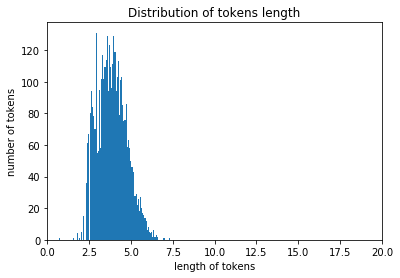

In [19]:
plt.hist(np.log(num_tokens), bins = 100)#有大有小取对数
plt.xlim((0,20))
plt.ylabel('number of tokens')
plt.xlabel('length of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [20]:
# 取tokens平均值并加上两个tokens的标准差，
# 假设tokens长度的分布为正态分布，则max_tokens这个值可以涵盖95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
print(max_tokens)

236


In [21]:
# 取tokens的长度为236时，大约95%的样本被涵盖
# 我们对长度不足的进行padding，超长的进行修剪
print(np.sum(num_tokens < max_tokens) / len(num_tokens))

0.9565


In [22]:
# 反向tokenize
# 为了之后来验证 我们定义一个function，用来把索引转换成可阅读的文本，这对于debug很重要。
# 用来将tokens转换为文本
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text

In [23]:
reverse = reverse_tokens(train_tokens[0])

In [24]:
# 经过tokenize再恢复成文本
# 可见标点符号都没有了
reverse

'早餐太差无论去多少人那边也不加食品的酒店应该重视一下这个问题了房间本身很好'

In [25]:
train_texts_orig[0]

'早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。\n\n房间本身很好。'

In [26]:
cn_model.index2word[1]

'的'

In [27]:
# 构建embedding matrix
# 现在我们来为模型准备embedding matrix（词向量矩阵），根据keras的要求，我们需要准备一个维度为(numwords, embeddingdim)的矩阵
# 【num words代表我们使用的词汇的数量，emdedding dimension在我们现在使用的预训练词向量模型中是300，
# 每一个词汇都用一个长度为300的向量表示】注意我们只选择使用前50k个使用频率最高的词，在这个预训练词向量模型中，
# 一共有260万词汇量，如果全部使用在分类问题上会很浪费计算资源，因为我们的训练样本很小，一共只有4k，如果我们有100k，
# 200k甚至更多的训练样本时，在分类问题上可以考虑减少使用的词汇量。

# 只使用大库前50000个词
num_words = 50000
# 初始化embedding_matrix，之后在keras上进行应用
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个 [num_words，embedding_dim] 的矩阵
# 维度为 50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')


In [28]:
embedding_matrix

array([[-8.017840e-01, -1.653400e-01,  3.050800e-02, ...,  1.065250e-01,
         5.534360e-01,  4.366500e-01],
       [-6.517470e-01,  5.359700e-01,  3.402710e-01, ...,  8.053990e-01,
         1.045930e-01,  1.936940e-01],
       [-4.123210e-01,  2.282610e-01,  2.071140e-01, ...,  8.087770e-01,
         5.675100e-02,  4.523740e-01],
       ...,
       [ 5.849840e-01,  1.121180e-01, -6.938330e-01, ..., -3.760570e-01,
         1.203500e-01, -1.059511e+00],
       [ 1.511710e-01, -3.200000e-04, -3.885760e-01, ..., -5.988550e-01,
         4.273530e-01, -3.922630e-01],
       [-4.536090e-01, -1.813600e-02, -1.306600e-01, ..., -6.608000e-02,
         3.566680e-01,  3.898050e-01]], dtype=float32)

In [29]:
# 检查index是否对应，
# 输出300意义为长度为300的embedding向量一一对应
np.sum( cn_model[cn_model.index2word[333]] == embedding_matrix[333] )

300

In [31]:
# padding(填充)和truncating(修剪)
# 我们把文本转换为tokens（索引）之后，每一串索引的长度并不相等，所以为了方便模型的训练我们需要把索引的长度标准化，
# 上面我们选择了236这个可以涵盖95%训练样本的长度，接下来我们进行padding和truncating，我们一般采用’pre’的方法，
# 这会在文本索引的前面填充0，因为根据一些研究资料中的实践，如果在文本索引后面填充0的话，会对模型造成一些不良影响。
# 进行padding和truncating， 输入的train_tokens是一个list
# 返回的train_pad是一个numpy array
from keras.preprocessing.sequence import pad_sequences

train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                            padding='pre', truncating='pre')

# 超出五万个词向量的词用0代替
train_pad[ train_pad>=num_words ] = 0


# 可见padding之后前面的tokens全变成0，文本在最后面
print(train_pad[33])

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'